In [1]:
# Get the parent directory
import sys
import os
import pandas as pd
import yaml
parent_dir = os.path.dirname(os.path.realpath("."))
sys.path.append(parent_dir)
import seaborn as sns
import pickle

In [2]:
from dreamsim import dreamsim
from PIL import Image
import torch

device = "cuda"
model, preprocess = dreamsim(pretrained=True, device=device)

/workspace/ds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cached ./models


Using cache found in ./models/facebookresearch_dino_main
/workspace/ds/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/workspace/ds/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [3]:
exp_dirs = [
'/workspace/OneActor/OneActor/experiments/adventurer_with_tousled_hair_comic_book/exp_2504141913',
'/workspace/OneActor/OneActor/experiments/young_woman_with_long_wavy_hair/exp_2504141856',
'/workspace/OneActor/OneActor/experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904']

In [4]:
res = []
for exp_dir in exp_dirs:
    target_path = f"{exp_dir}/target.jpg"
    for _, dir, _ in os.walk(exp_dir):
        break
    dir = [d for d in dir if 'output' in d]
    for d in dir:
        with open(f"{exp_dir}/{d}/log_train.log", 'r') as config_file:
            config = yaml.safe_load(config_file)
        for _, _, files in os.walk(f"{exp_dir}/{d}/inference"):
            break
        for f in files:
            res.append({
                'thema': exp_dir.split("/")[5],
                'exp': exp_dir.split("/")[6],
                'model': d,
                'config': config,
                'target_img_path': target_path,
                'gen_img_path': f"{exp_dir}/{d}/inference/{f}",
                'prompt':('_'.join(f.split(".")[0].split("_")[:-1])),
                'epoch':0 if f.split(".")[0].split("_")[-1] == 'sdxl' else int(f.split(".")[0].split("_")[-1])
            })

In [5]:
for n, r in enumerate(res):
    img1 = preprocess(Image.open(r['target_img_path'])).to(device)
    img2 = preprocess(Image.open(r['gen_img_path'])).to(device)
    distance = model(img1, img2)
    res[n]['distance'] = float(distance.cpu().detach().numpy()[0])

In [6]:
for n, r in enumerate(res):
    if r['config']['use_mask']:
        title = f"mask, p={r['config']['mask_power']}, a={r['config']['mask_alpha']}"
    elif r['config']['use_zone']:
        title = f"zone, a={r['config']['zone_alpha']}"
    else:
        title="OneActor"
    res[n]['title'] = title

In [15]:
df = pd.DataFrame(res)
df = df[['thema', 'exp', 'model', 'prompt',
       'epoch', 'distance', 'title']]
df[df['epoch'] == 100].groupby(['title']).agg({'distance':'mean', 'exp':'count'})

,distance,exp
title,,
OneActor,0.361447,14
"mask, p=0.5, a=0.5",0.334821,14
"mask, p=1.0, a=0.25",0.356664,14
"mask, p=1.0, a=0.5",0.348043,14
"mask, p=2.0, a=0.5",0.356616,14
"zone, a=0.25",0.340573,14
"zone, a=0.5",0.354290,14


In [16]:
df_agg=df.groupby(['epoch', 'title']).agg({'distance':'mean', 'exp':'count'}).reset_index()

<Axes: xlabel='epoch', ylabel='distance'>

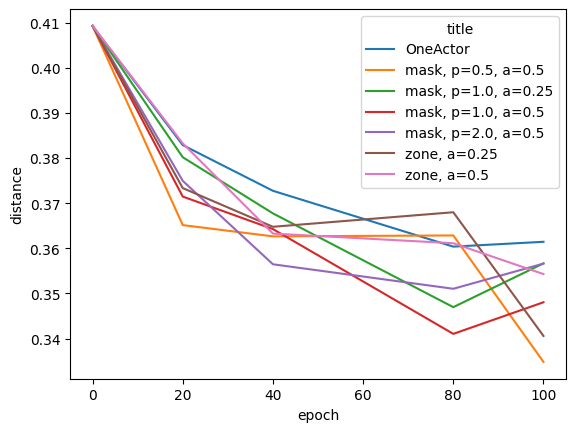

In [17]:
sns.lineplot(data=df_agg, x="epoch", y="distance", hue="title")

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'zone, a=0.25'),
  Text(1, 0, 'mask, p=1.0, a=0.25'),
  Text(2, 0, 'mask, p=2.0, a=0.5'),
  Text(3, 0, 'mask, p=0.5, a=0.5'),
  Text(4, 0, 'zone, a=0.5'),
  Text(5, 0, 'mask, p=1.0, a=0.5'),
  Text(6, 0, 'OneActor')])

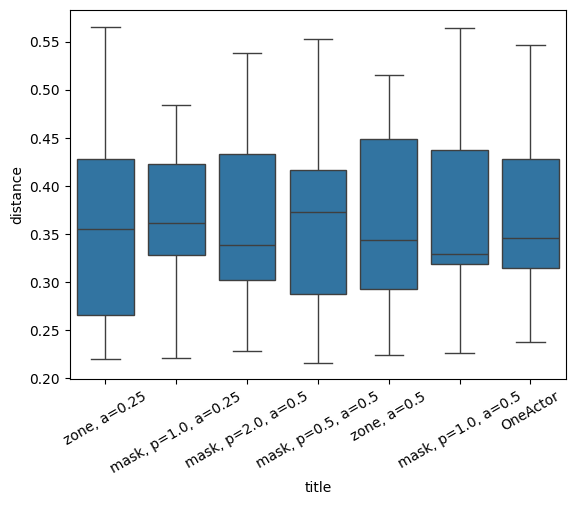

In [18]:
from matplotlib import pyplot as plt
sns.boxplot(data=df[df['epoch'] == 40], x="title", y="distance")
plt.xticks(rotation=30)

In [19]:
df = df.merge(df[df['title'] == "OneActor"][['thema', 'prompt', 'epoch', 'distance']].rename(columns={'distance':'OA_distance'}), on=['thema', 'prompt', 'epoch'])

In [20]:
df['diff'] = df['OA_distance'] - df['distance']

In [22]:
df[(df['epoch'] == 100)].sort_values('diff', ascending=False)

,thema,exp,model,prompt,epoch,distance,title,OA_distance,diff
405,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151631,the_effel_tower_as_a_background_step,100,0.322569,"mask, p=0.5, a=0.5",0.439687,0.117118
400,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151631,the_statue_of_liberty_as_a_background_step,100,0.467657,"mask, p=0.5, a=0.5",0.559450,0.091793
385,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151724,a_city_as_background_step,100,0.266081,"mask, p=2.0, a=0.5",0.353627,0.087546
330,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504152002,the_effel_tower_as_a_background_step,100,0.356058,"zone, a=0.25",0.439687,0.083629
410,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151631,a_city_as_background_step,100,0.279519,"mask, p=0.5, a=0.5",0.353627,0.074107
...,...,...,...,...,...,...,...,...,...
245,young_woman_with_long_wavy_hair,exp_2504141856,output_2504142222,walking_on_sunset_beach_step,100,0.548196,"mask, p=0.5, a=0.5",0.502942,-0.045254
225,young_woman_with_long_wavy_hair,exp_2504141856,output_2504142250,walking_on_sunset_beach_step,100,0.548393,"mask, p=2.0, a=0.5",0.502942,-0.045451
55,adventurer_with_tousled_hair_comic_book,exp_2504141913,output_2504151439,eating_a_burger_step,100,0.430669,"mask, p=2.0, a=0.5",0.381937,-0.048732
105,adventurer_with_tousled_hair_comic_book,exp_2504141913,output_2504151343,eating_a_burger_step,100,0.433534,"zone, a=0.5",0.381937,-0.051597


In [24]:
for exp_dir in exp_dirs:
    with open(f"{exp_dir}/metric_ds.pickle", 'wb') as handle:
        pickle.dump(df[
                    (df['thema'] == exp_dir.split("/")[5]) & (df['exp'] == exp_dir.split("/")[6])
                    ], handle)